In [176]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

from numpy.random import default_rng
RANDOM_STATE = 2 # random state for default_rng
rng = default_rng(RANDOM_STATE)


import random
#import altair as alt
from tqdm import tqdm
import datetime

# CHECKLIST for Kaggle variant
# USE_ALL_STOCK_IDS False to check then True
# USE_TEST_LOCAL_6_ITEMS must be False else we override the local test data
# TEST_SIZE must be 0 to get all items
# Check on Kaggle that "internet" is disabled
# First run with "USE_ALL_STOCK_IDS=False", flip to True, Save Version, it'll take 30 mins to run

# CHECKLIST for home variant
# USE_ALL_STOCK_IDS False for fast dev, True for proper testing
# USE_TEST_LOCAL_6_ITEMS False for fast dev, True for proper testing
# NBR_FOR_SUBSET_OF_STOCK_IDS 4 for quick testing

t1_notebook_start = datetime.datetime.utcnow()

if os.environ.get('USER') == 'ian':
    ENV_HOME = True
    import ipython_memory_usage
    %ipython_memory_usage_start
    USE_ALL_STOCK_IDS = True
    NBR_FOR_SUBSET_OF_STOCK_IDS = 4
    TEST_SIZE = 0.25 # for single train/test split
    #USE_TEST_LOCAL_6_ITEMS = True # robust local testing at home
    USE_TEST_LOCAL_6_ITEMS = False # robust local testing at home TEMPORARY WHILST DEBUGGING
    
    from joblib import Memory
    memory = Memory(location='joblib_cache', verbose=0)

else:
    ENV_HOME = False
    USE_ALL_STOCK_IDS = False # for KAGGLE on first-upload for a quick test
    TEST_SIZE = 0
    USE_TEST_LOCAL_6_ITEMS = False
    NBR_FOR_SUBSET_OF_STOCK_IDS = 4
    # kaggle notes:
    # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
    # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


if USE_ALL_STOCK_IDS:
    NBR_FOR_SUBSET_OF_STOCK_IDS=None
print(f'ENV_HOME: {ENV_HOME}, TEST_SIZE {TEST_SIZE}, USE_ALL_STOCK_IDS {USE_ALL_STOCK_IDS}, USE_TEST_LOCAL_6_ITEMS {USE_TEST_LOCAL_6_ITEMS}')
print(f'NBR_FOR_SUBSET_OF_STOCK_IDS: {NBR_FOR_SUBSET_OF_STOCK_IDS}')

ENV_HOME: True, TEST_SIZE 0.25, USE_ALL_STOCK_IDS True, USE_TEST_LOCAL_6_ITEMS False
NBR_FOR_SUBSET_OF_STOCK_IDS: None
In [176] used 0.0312 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 2033.64 MiB


In [177]:
# OR PASTE IN UTILITY CODE HERE FOR KAGGLE
from utility import make_unique_time_ids, get_training_stock_ids, rmspe_score
from utility import ROOT, TEST_CSV, TRAIN_CSV

In [177] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 2033.64 MiB


## Load train set

In [178]:
stock_ids = get_training_stock_ids('book_train.parquet') # all stocks by default

if not USE_ALL_STOCK_IDS:
    # choose a random subset
    print(f"Using a subset of {NBR_FOR_SUBSET_OF_STOCK_IDS}")
    rng.shuffle(stock_ids)
    #random.shuffle(stock_ids)
    stock_ids = stock_ids[:NBR_FOR_SUBSET_OF_STOCK_IDS]
else:
    print("Using all")
stock_ids[:3] # expect 59, 58, 23 if we're using all or 76, 73, 0 on the RANDOM_STATE of 1 if we don't use all stock ids

Using all


[59, 58, 23]

In [178] used 0.0078 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 2033.64 MiB


In [179]:
df_train_all = pd.read_csv(TRAIN_CSV)
df_train_all = df_train_all.set_index(['stock_id', 'time_id'])
print(df_train_all.shape)
#rows_for_stock_id_0 = df_train_all.query('stock_id == 0').shape[0]
#rows_for_stock_id_0

(428932, 1)
In [179] used 0.0078 MiB RAM in 0.25s, peaked 0.00 MiB above current, total RAM usage 2033.65 MiB


In [180]:
def show_details(df):
    try:
        nbr_index_levels = len(df.index.levels)
    except AttributeError:
        nbr_index_levels = 1
    nbr_nulls = df.isnull().sum().sum()
    #nulls_msg = "Has no nulls"
    #if nbr_nulls==0:
    nulls_msg = f"{nbr_nulls} nulls"
    is_view_msg = f'is_view {df_train_all._data.is_view}'
    is_single_block_msg = f'is_single_block {df_train_all._data.is_single_block}'
    is_consolidated_msg = f'is_consolidated {df_train_all._data.is_consolidated()}'    
    print(f'[{nbr_index_levels}c] {df.shape[0]:,}x{df.shape[1]:,}, {nulls_msg}, {is_view_msg}, {is_single_block_msg}, {is_consolidated_msg}')

show_details(df_train_all)

[2c] 428,932x1, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [180] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 2033.65 MiB


In [181]:
all_time_ids = df_train_all.reset_index().time_id.unique()
#np.random.shuffle(all_time_ids) # shuffle the time_ids
rng.shuffle(all_time_ids)
print(f"We have {len(all_time_ids):,} time ids")
time_ids_train, time_ids_test = make_unique_time_ids(all_time_ids, test_size=TEST_SIZE)
assert len(time_ids_train) + len(time_ids_test) == len(all_time_ids)
assert len(time_ids_train.intersection(time_ids_test)) == 0, "Expecting no overlap between train and test time ids"
print(f"Example time ids for training, min first: {sorted(list(time_ids_train))[:5]}")

We have 3,830 time ids
Taking 2,872 for train and 958 for test
Example time ids for training, min first: [5, 11, 16, 31, 62]
In [181] used 0.0000 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 2033.65 MiB


In [182]:
# make feature columns
def make_features_stats(df_book, agg_type, cols):
    features_var1 = df_book.groupby(['stock_id', 'time_id'])[cols].agg(agg_type)
    #print(type(features_var1))
    if isinstance(features_var1, pd.Series):
        # .size yields a series not a df
        #features_var1.name = str(agg_type)
        features_var1 = pd.DataFrame(features_var1, columns=[agg_type])
        #pass
    else:
        features_var1_col_names = [f"{col}_{agg_type}" for col in cols]
        features_var1.columns = features_var1_col_names
    return features_var1

if True: # lightweight tests
    df_book_train_stock_XX = pd.read_parquet(os.path.join(ROOT, f"book_train.parquet/stock_id=0"))
    df_book_train_stock_XX["stock_id"] = 0
    df_book_train_stock_XX = df_book_train_stock_XX.set_index(['stock_id', 'time_id'])
    display(make_features_stats(df_book_train_stock_XX, 'nunique', ['ask_size1']).head())

ask_size1_nunique
stock_id time_id                   
0        5                       67
         11                      26
         16                      22
         31                      30
         62                      54

In [182] used 110.0391 MiB RAM in 0.42s, peaked 0.00 MiB above current, total RAM usage 2143.69 MiB


In [183]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In [183] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 2143.69 MiB


In [184]:
def _realized_volatility_weighted_sub(ser, weights):
    ser_weighted = ser * weights
    return np.sqrt(np.sum(ser_weighted**2))

def realized_volatility_weighted(ser, weights_type):
    """Weighted volatility"""
    # as a numpy array
    # we drop from 12us to 3us by adding @njit to the _sub function
    # we can't make _sub a closure, it loses all compilation benefits
    # and we can't add njit(cache=True) in Jupyter as it can't
    # find a cache location    
    # as a Series we have 5us and 15us w/wo @njit respectively
    if isinstance(ser, pd.Series):
        ser = ser.to_numpy()
    nbr_items = ser.shape[0]
    if weights_type == 'uniform':
        weights = np.ones(nbr_items)
    elif weights_type == 'linear':
        weights = np.linspace(0.1, 1, nbr_items) # linear increasing weight
    elif weights_type == 'half0half1':
        half_way = int(ser.shape[0] / 2)
        weights = np.concatenate((np.zeros(half_way), np.ones(ser.shape[0] - half_way))) # 0s then 1s weight
    elif weights_type == 'geom':
        weights = np.geomspace(0.01, 1, nbr_items) # geometric increase
    #assert isinstance(weights_type, str) == False, f"Must not be a string like '{weights}' at this point"
    return _realized_volatility_weighted_sub(ser, weights)

if True:
    series_log_return = pd.Series(np.linspace(0, 10, 6))
    print(realized_volatility_weighted(series_log_return, weights_type="uniform"))

    #%timeit realized_volatility_weighted(series_log_return, weights_type="uniform")

14.832396974191326
In [184] used 0.0078 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 2143.70 MiB


In [185]:
def realized_volatility_weightedOLD(ser, weights=None):
    """Weighted volatility"""
    #ser = series_log_return
    if weights == "uniform":
        weight_arr = np.ones(ser.shape[0])
    elif weights == 'linear':
        weight_arr = np.linspace(0.1, 1, ser.shape[0]) # linear increasing weight
    #assert weights is not None, "Must have set a valid description before here"
    #ser_weighted = ser * weights
    return np.sqrt(np.sum((ser * weight_arr)**2))

if False:
    # example usage
    series_log_return = np.linspace(0, 10, 6)
    weights = np.linspace(0.1, 1, series_log_return.shape[0]) # linear increasing weight

    half_way = int(series_log_return.shape[0] / 2)
    weights = np.concatenate((np.zeros(half_way), np.ones(series_log_return.shape[0] - half_way))) # 0s then 1s weight

    weights = np.ones(series_log_return.shape[0]) # use all items equally
    assert weights.shape[0] == series_log_return.shape[0]
    realized_volatility_weighted(series_log_return, 'linear')

In [185] used 0.0156 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 2143.71 MiB


In [186]:
def make_wap(df_book_data, num=1, wap_colname="wap"):
    """Modifies df_book_data"""
    assert num==1 or num==2
    wap_numerator = (df_book_data[f'bid_price{num}'] * df_book_data[f'ask_size{num}'] +
                                     df_book_data[f'ask_price{num}'] * df_book_data[f'bid_size{num}'])
    wap_denominator = df_book_data[f'bid_size{num}'] + df_book_data[f'ask_size{num}']
    df_book_data[wap_colname] = wap_numerator / wap_denominator

@memory.cache
def make_realized_volatility(df_book_data, log_return_name='log_return', wap_colname='wap', weights=None):
    """Consume wap column"""
    df_book_data[log_return_name] = df_book_data.groupby(['stock_id', 'time_id'])[wap_colname].apply(log_return)
    df_book_data = df_book_data[~df_book_data[log_return_name].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['stock_id', 'time_id'])[log_return_name].agg(realized_volatility_weighted, weights))
    return df_realized_vol_per_stock

In [186] used 0.1055 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 2143.82 MiB


In [187]:
if True: # lightweight tests
    df_book_train_stock_XX = pd.read_parquet(os.path.join(ROOT, f"book_train.parquet/stock_id=0"))
    df_book_train_stock_XX["stock_id"] = 0
    df_book_train_stock_XX = df_book_train_stock_XX.set_index(['stock_id', 'time_id'])
    make_wap(df_book_train_stock_XX, 2) # adds 'wap' column
    #df_realized_vol_per_stockXX = make_realized_volatility(df_book_train_stock_XX, log_return_name="log_return2", weights='linear')
    #display(df_realized_vol_per_stockXX)

In [187] used 99.1680 MiB RAM in 0.28s, peaked 0.00 MiB above current, total RAM usage 2242.99 MiB


In [210]:
@memory.cache
def load_data_build_features(stock_id, ROOT, filename, cols, df_target):
    # filename e.g. book_train.parquet
    assert isinstance(stock_id, int)
    df_book_train_stock_X = pd.read_parquet(
        os.path.join(ROOT, f"{filename}/stock_id={stock_id}")
    )
    df_book_train_stock_X["stock_id"] = stock_id
    df_book_train_stock_X = df_book_train_stock_X.set_index(['stock_id', 'time_id'])
    #assert df_book_train_stock_X.shape[0] > rows_for_stock_id_0, (df_book_train_stock_X.shape[0], rows_for_stock_id_0)
    
    #df_book_train_stock_X_gt500 = df_book_train_stock_X.query("seconds_in_bucket>500").copy()
    #df_realized_vol_per_stock_short500 = add_wap_make_realized_volatility(df_book_train_stock_X_gt500, log_return_name='log_return_gt500sec')
    #df_book_train_stock_X_gt300 = df_book_train_stock_X.query("seconds_in_bucket>300").copy()
    #df_realized_vol_per_stock_short300 = add_wap_make_realized_volatility(df_book_train_stock_X_gt300, log_return_name='log_return_gt300sec')
    make_wap(df_book_train_stock_X, 2, "wap2") 
    df_realized_vol_per_stock_wap2_uniform = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return2_uniform", wap_colname="wap2", weights='uniform')    
    df_realized_vol_per_stock_wap2_linear = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return2_linear", wap_colname="wap2", weights='linear')
    df_realized_vol_per_stock_wap2_half0half1 = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return2_half0half1", wap_colname="wap2", weights='half0half1')
    make_wap(df_book_train_stock_X, 1, "wap") # adds 'wap' column
    df_realized_vol_per_stock_wap1_uniform = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return1_uniform", weights='uniform')
    df_realized_vol_per_stock_wap1_linear = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return1_linear", weights='linear')
    df_realized_vol_per_stock_wap1_half0half1 = make_realized_volatility(df_book_train_stock_X, log_return_name="log_return1_half0half1", weights='half0half1')
    
    features_var1 = make_features_stats(df_book_train_stock_X, 'var', cols)
    features_mean1 = make_features_stats(df_book_train_stock_X, 'mean', cols)
    features_size1 = make_features_stats(df_book_train_stock_X, 'size', cols)
    features_min1 = make_features_stats(df_book_train_stock_X, 'min', cols)
    features_max1 = make_features_stats(df_book_train_stock_X, 'max', cols)
    features_nunique1 = make_features_stats(df_book_train_stock_X, 'nunique', cols)
    
    df_train_stock_X = df_target.query('stock_id == @stock_id')
    to_merge = [df_train_stock_X, 
                features_var1, features_mean1, features_size1, 
                features_min1, features_max1, features_nunique1,
                df_realized_vol_per_stock_wap1_uniform,
                df_realized_vol_per_stock_wap2_uniform,
                df_realized_vol_per_stock_wap1_linear,
                df_realized_vol_per_stock_wap2_linear,
                df_realized_vol_per_stock_wap1_half0half1,
                df_realized_vol_per_stock_wap2_half0half1]
    row_lengths = [df.shape[0] for df in to_merge]
    assert len(set(row_lengths)) == 1, row_lengths # should all be same length
    train_merged = pd.concat(to_merge, axis=1)
    
    if 'target' in train_merged.columns:
        # no need to check for duplication on the test set
        features = train_merged.drop(columns='target').columns
        #print(features)
        assert len(set(features)) == len(features), f"Feature duplication! {len(set(features))} vs {len(features)}"

    return train_merged

#if 'memory' in dir():
#    # only setup local cache if we're running locally in development
#    load_data_build_features = memory.cache(load_data_build_features)
    
cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2',] 
cols += ['bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

if True:    
    # test...
    train_mergedXX = load_data_build_features(0, ROOT, 'book_train.parquet', cols, df_train_all)
    display(train_mergedXX)

target  bid_price1_var  ask_price1_var  bid_price2_var  \
stock_id time_id                                                             
0        5        0.004136    3.557702e-07    3.609267e-07    3.278967e-07   
         11       0.001445    8.048454e-08    4.782809e-08    5.987733e-08   
         16       0.002168    5.057495e-07    6.204843e-07    5.307066e-07   
         31       0.002195    4.746649e-07    3.223060e-07    5.349445e-07   
         62       0.001747    4.740689e-08    3.653909e-08    5.247379e-08   
...                    ...             ...             ...             ...   
         32751    0.002611    3.989057e-07    5.059281e-07    3.846314e-07   
         32753    0.001190    1.837252e-07    2.433933e-07    2.033434e-07   
         32758    0.004264    5.668076e-07    4.536424e-07    6.043470e-07   
         32763    0.004352    1.058614e-07    1.051107e-07    1.070506e-07   
         32767    0.001084    5.710588e-07    5.752923e-07    6.009845e-07   

                  ask_price2_var  bid_size1_var  ask_size1_var  bid_size2_var  \
stock_id time_id                                                                
0        5          3.649655e-07    6592.215309    4338.669743    7348.756507   
         11         4.715270e-08   15492.325402    9691.320578    8465.001985   
         16         6.152997e-07    4978.115912    9259.747269    5674.860251   
         31         3.222207e-07    8093.880602   10996.043697    5778.103922   
         62         3.838027e-08    9499.414513    9603.210909    7059.243117   
...                          ...            ...            ...            ...   
         32751      4.818288e-07    9490.991605   10394.996610    4828.041246   
         32753      2.618266e-07   28270.493701   20407.077646   15863.063249   
         32758      4.448702e-07    6587.428917    7851.263511    2219.748436   
         32763      1.431541e-07    7244.247983    6607.922889    8062.183603   
         32767      5.970896e-07    9402.179206   10214.490359   12848.133608   

                  ask_size2_var  bid_price1_mean  ...  bid_size1_nunique  \
stock_id time_id                                  ...                      
0        5          5184.163572         1.003314  ...                 44   
         11         7875.531633         1.000011  ...                 58   
         16         4586.227415         0.999204  ...                 43   
         31         6483.167437         0.998445  ...                 24   
         62         4527.422208         0.999407  ...                 23   
...                         ...              ...  ...                ...   
         32751      9333.874374         0.997639  ...                 54   
         32753     10575.195643         1.000141  ...                 36   
         32758      5428.886648         0.999334  ...                 37   
         32763      5552.617083         1.002087  ...                 39   
         32767      6756.769515         0.998886  ...                 23   

                  ask_size1_nunique  bid_size2_nunique  ask_size2_nunique  \
stock_id time_id                                                            
0        5                       67                 32                 46   
         11                      26                 26                 44   
         16                      22                 43                 21   
         31                      30                 24                 34   
         62                      54                 26                 43   
...                             ...                ...                ...   
         32751                   63                 31                 57   
         32753                   59                 39                 40   
         32758                   42                 35                 20   
         32763                   42                 27                 41   
         32767                   50   

In [210] used -71.6836 MiB RAM in 12.49s, peaked 173.16 MiB above current, total RAM usage 2250.65 MiB


In [189]:
from joblib import Parallel, delayed
print(f'Iterating over {len(stock_ids)} stocks:')

all_train_merged = Parallel(n_jobs=-1, verbose=10)(delayed(load_data_build_features)(stock_id, ROOT, 'book_train.parquet', cols, df_train_all) for stock_id in stock_ids)

Iterating over 112 stocks:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1954s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    2.1s finished


In [189] used -192.8281 MiB RAM in 2.27s, peaked 168.30 MiB above current, total RAM usage 2050.09 MiB


In [190]:
# join all the partial results back together
train_merged = pd.concat(all_train_merged)
show_details(train_merged)

[2c] 428,932x48, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [190] used -10.8086 MiB RAM in 0.31s, peaked 39.49 MiB above current, total RAM usage 2039.29 MiB


In [191]:
train_merged.head()

target  bid_price1_var  ask_price1_var  bid_price2_var  \
stock_id time_id                                                             
59       5        0.004072    1.539389e-07    1.544176e-07    1.349132e-07   
         11       0.001489    3.412355e-07    4.039657e-07    3.298110e-07   
         16       0.002563    5.515992e-07    5.405377e-07    5.369475e-07   
         31       0.002323    4.119776e-08    9.782350e-08    5.722407e-08   
         62       0.002398    2.799989e-07    3.039634e-07    2.906845e-07   

                  ask_price2_var  bid_size1_var  ask_size1_var  bid_size2_var  \
stock_id time_id                                                                
59       5          1.465483e-07   11855.387055    6892.936853    4510.521751   
         11         4.177058e-07   22438.854139   32757.977261   35927.916710   
         16         5.369036e-07   10481.927458   12315.572839    6729.414078   
         31         9.959539e-08    6566.613651    7043.215464    5424.648518   
         62         2.920635e-07   16026.168376   12337.165290    9310.249809   

                  ask_size2_var  bid_price1_mean  ...  bid_size1_nunique  \
stock_id time_id                                  ...                      
59       5          5765.414169         1.000904  ...                 55   
         11        16786.511136         1.000577  ...                 66   
         16         6091.421681         0.999024  ...                 18   
         31         8061.372315         1.000029  ...                 40   
         62         7555.724324         0.997103  ...                 59   

                  ask_size1_nunique  bid_size2_nunique  ask_size2_nunique  \
stock_id time_id                                                            
59       5                       91                 42                 63   
         11                      58                 34                 39   
         16                      69                 19                 39   
         31                      31                 34                 35   
         62                      38                 43                 19   

                  log_return1_uniform  log_return2_uniform  \
stock_id time_id                                             
59       5                   0.002861             0.003991   
         11                  0.002905             0.004020   
         16                  0.002423             0.003329   
         31                  0.002573             0.003381   
         62                  0.002345             0.003060   

                  log_return1_linear  log_return2_linear  \
stock_id time_id                                           
59       5                  0.001431            0.002188   
         11                 0.001629            0.002768   
         16                 0.001488            0.002022   
         31                 0.001407            0.002040   
         62                 0.001263            0.001727   

                  log_return1_half0half1  log_return2_half0half1  
stock_id time_id                                                  
59       5                      0.001584                0.002576  
         11                     0.001959                0.003312  
         16                     0.001859                0.002353  
         31                     0.001574                0.002446  
         62                     0.001524                0.002025  

[5 rows x 48 columns]

In [191] used 0.0000 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 2039.29 MiB


In [192]:
features = train_merged.drop(columns='target').columns
print(features)
assert len(set(features)) == len(features), f"{len(set(features))} vs {len(features)} features, we should not have any duplicates"

Index(['bid_price1_var', 'ask_price1_var', 'bid_price2_var', 'ask_price2_var',
       'bid_size1_var', 'ask_size1_var', 'bid_size2_var', 'ask_size2_var',
       'bid_price1_mean', 'ask_price1_mean', 'bid_price2_mean',
       'ask_price2_mean', 'bid_size1_mean', 'ask_size1_mean', 'bid_size2_mean',
       'ask_size2_mean', 'size', 'bid_price1_min', 'ask_price1_min',
       'bid_price2_min', 'ask_price2_min', 'bid_size1_min', 'ask_size1_min',
       'bid_size2_min', 'ask_size2_min', 'bid_price1_max', 'ask_price1_max',
       'bid_price2_max', 'ask_price2_max', 'bid_size1_max', 'ask_size1_max',
       'bid_size2_max', 'ask_size2_max', 'bid_price1_nunique',
       'ask_price1_nunique', 'bid_price2_nunique', 'ask_price2_nunique',
       'bid_size1_nunique', 'ask_size1_nunique', 'bid_size2_nunique',
       'ask_size2_nunique', 'log_return1_uniform', 'log_return2_uniform',
       'log_return1_linear', 'log_return2_linear', 'log_return1_half0half1',
       'log_return2_half0half1'],
      dtype

# Features

In [193]:
def train_test_split(df, target_col, time_ids_train, time_ids_test):
    X_train = df.query('time_id in @time_ids_train').drop(columns=[target_col, 'time_id'])
    X_test = df.query('time_id in @time_ids_test').drop(columns=[target_col, 'time_id'])
    y_train = df.query('time_id in @time_ids_train')[target_col]
    y_test = df.query('time_id in @time_ids_test')[target_col]
    return X_train, X_test, y_train, y_test

feature_cols = list(features) + ['stock_id']
X_train, X_test, y_train, y_test = train_test_split(train_merged.reset_index()[feature_cols+['time_id', 'target']], 'target', time_ids_train, time_ids_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((321646, 48), (107286, 48), (321646,), (107286,))

In [193] used 179.1484 MiB RAM in 0.46s, peaked 84.89 MiB above current, total RAM usage 2355.89 MiB


In [194]:
X_train.head(3)

,bid_price1_var,ask_price1_var,bid_price2_var,ask_price2_var,bid_size1_var,ask_size1_var,bid_size2_var,ask_size2_var,bid_price1_mean,ask_price1_mean,...,ask_size1_nunique,bid_size2_nunique,ask_size2_nunique,log_return1_uniform,log_return2_uniform,log_return1_linear,log_return2_linear,log_return1_half0half1,log_return2_half0half1,stock_id
0,1.539389e-07,1.544176e-07,1.349132e-07,1.465483e-07,11855.387055,6892.936853,4510.521751,5765.414169,1.000904,1.001389,...,91,42,63,0.002861,0.003991,0.001431,0.002188,0.001584,0.002576,59
1,3.412355e-07,4.039657e-07,3.298110e-07,4.177058e-07,22438.854139,32757.977261,35927.916710,16786.511136,1.000577,1.001177,...,58,34,39,0.002905,0.004020,0.001629,0.002768,0.001959,0.003312,59
2,5.515992e-07,5.405377e-07,5.369475e-07,5.369036e-07,10481.927458,12315.572839,6729.414078,6091.421681,0.999024,0.999396,...,69,19,39,0.002423,0.003329,0.001488,0.002022,0.001859,0.002353,59


In [194] used 0.0000 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 2355.89 MiB


In [195]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((321646, 48), (107286, 48), (321646,), (107286,))

In [195] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 2355.89 MiB


# ML on a train/test split

In [196]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor

In [196] used -0.0234 MiB RAM in 0.11s, peaked 0.02 MiB above current, total RAM usage 2355.87 MiB


In [197]:
#est = LinearRegression()
#est = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=RANDOM_STATE) # default n_estimators==100
#est = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE) # default n_estimators==100
#est = GradientBoostingRegressor(random_state=RANDOM_STATE)
#est = HistGradientBoostingRegressor(random_state=RANDOM_STATE)

# https://xgboost.readthedocs.io/en/latest/python/python_api.html
#tree_method='exact' default
#est = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
est = xgb.XGBRegressor(tree_method='hist', )

#est = LGBMRegressor()

est.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='hist', validate_parameters=1, verbosity=None)

In [197] used 0.1406 MiB RAM in 4.13s, peaked 117.79 MiB above current, total RAM usage 2356.01 MiB


In [198]:
from sklearn.metrics import r2_score

print(f"USE_ALL_STOCK_IDS: {USE_ALL_STOCK_IDS}")

print(f"{df_train_all.reset_index().stock_id.unique().shape[0]} unique stock ids, test set is {TEST_SIZE*100:0.1f}%")
print(f"Features:", feature_cols)
print(est)
if X_test.shape[0] > 0:
    y_pred = est.predict(X_test)
    score = r2_score(y_test, y_pred)
    rmspe = rmspe_score(y_test, y_pred)
    print(f"rmspe score {rmspe:0.3f}, r^2 score {score:0.3f} on {y_pred.shape[0]:,} predictions")
else:
    print('No testing rows in X_test')

USE_ALL_STOCK_IDS: True
112 unique stock ids, test set is 25.0%
Features: ['bid_price1_var', 'ask_price1_var', 'bid_price2_var', 'ask_price2_var', 'bid_size1_var', 'ask_size1_var', 'bid_size2_var', 'ask_size2_var', 'bid_price1_mean', 'ask_price1_mean', 'bid_price2_mean', 'ask_price2_mean', 'bid_size1_mean', 'ask_size1_mean', 'bid_size2_mean', 'ask_size2_mean', 'size', 'bid_price1_min', 'ask_price1_min', 'bid_price2_min', 'ask_price2_min', 'bid_size1_min', 'ask_size1_min', 'bid_size2_min', 'ask_size2_min', 'bid_price1_max', 'ask_price1_max', 'bid_price2_max', 'ask_price2_max', 'bid_size1_max', 'ask_size1_max', 'bid_size2_max', 'ask_size2_max', 'bid_price1_nunique', 'ask_price1_nunique', 'bid_price2_nunique', 'ask_price2_nunique', 'bid_size1_nunique', 'ask_size1_nunique', 'bid_size2_nunique', 'ask_size2_nunique', 'log_return1_uniform', 'log_return2_uniform', 'log_return1_linear', 'log_return2_linear', 'log_return1_half0half1', 'log_return2_half0half1', 'stock_id']
XGBRegressor(base_score

/home/ian/miniconda3/envs/optiver_volatility/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [198] used 0.0000 MiB RAM in 0.30s, peaked 39.07 MiB above current, total RAM usage 2356.01 MiB


In [199]:
%%time

scores = []
if TEST_SIZE > 0:
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html
    # note the splits appear to be deterministic, possibly on discovery order
    from sklearn.model_selection import GroupKFold
    train_merged_no_idx = train_merged.reset_index()
    groups = train_merged_no_idx['time_id']
    group_kfold = GroupKFold(n_splits=3)
    X_all = train_merged_no_idx[feature_cols]
    y_all = train_merged_no_idx['target']
    print(group_kfold.get_n_splits(X_all, y_all, groups))
    for train_index, test_index in group_kfold.split(X_all, y_all, groups):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_all.loc[train_index], X_all.loc[test_index]
        y_train, y_test = y_all.loc[train_index], y_all.loc[test_index]
        est.fit(X_train, y_train)
        y_pred = est.predict(X_test)
        score = r2_score(y_test, y_pred)
        rmspe = rmspe_score(y_test, y_pred)
        print(f"rmspe score {rmspe:0.3f}, r^2 score {score:0.3f} on {y_pred.shape[0]:,} predictions")
        scores.append({'r2': score, 'rmspe': rmspe})

3
TRAIN: [     1      2      4 ... 428927 428928 428930] TEST: [     0      3      6 ... 428926 428929 428931]


/home/ian/miniconda3/envs/optiver_volatility/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


rmspe score 0.288, r^2 score 0.805 on 142,904 predictions
TRAIN: [     0      1      3 ... 428927 428929 428931] TEST: [     2      5      8 ... 428925 428928 428930]


/home/ian/miniconda3/envs/optiver_volatility/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


rmspe score 0.283, r^2 score 0.810 on 143,014 predictions
TRAIN: [     0      2      3 ... 428929 428930 428931] TEST: [     1      4      7 ... 428921 428924 428927]


/home/ian/miniconda3/envs/optiver_volatility/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


rmspe score 0.287, r^2 score 0.814 on 143,014 predictions
CPU times: user 1min 26s, sys: 335 ms, total: 1min 27s
Wall time: 12.5 s
In [199] used -34.3477 MiB RAM in 12.57s, peaked 157.02 MiB above current, total RAM usage 2321.66 MiB


In [209]:
if len(scores) > 0:
    # only show results if we've used cross validation
    df_scores = pd.DataFrame(scores).T
    folds = df_scores.columns.values
    df_scores['std'] = df_scores[folds].std(axis=1)
    df_scores['mean'] = df_scores[folds].mean(axis=1)
    display(df_scores)

,0,1,2,std,mean
r2,0.804593,0.809950,0.814294,0.004859,0.809612
rmspe,0.287959,0.282747,0.286829,0.002742,0.285845


In [209] used -0.0234 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 2322.34 MiB


In [201]:
if X_test.shape[0] > 0:
    df_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    df_preds['abs_diff'] = (df_preds['y_test'] - df_preds['y_pred']).abs()
    display(df_preds.sort_values('abs_diff', ascending=False))

,y_test,y_pred,abs_diff
98144,0.049287,0.016362,3.292516e-02
32451,0.035998,0.004487,3.151184e-02
377278,0.042814,0.017530,2.528422e-02
200315,0.026616,0.002138,2.447865e-02
380982,0.035859,0.011530,2.432926e-02
...,...,...,...
92737,0.001790,0.001790,4.039202e-08
96271,0.001989,0.001989,4.000115e-08
267932,0.002065,0.002065,3.554469e-08
32159,0.003165,0.003165,3.474792e-08


In [201] used 0.0000 MiB RAM in 0.19s, peaked 0.00 MiB above current, total RAM usage 2321.66 MiB


In [202]:
#item_to_debug = 32451
#train_merged.reset_index().loc[item_to_debug][['stock_id', 'time_id', 'target']]

In [202] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 2321.66 MiB


/home/ian/miniconda3/envs/optiver_volatility/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/ian/miniconda3/envs/optiver_volatility/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


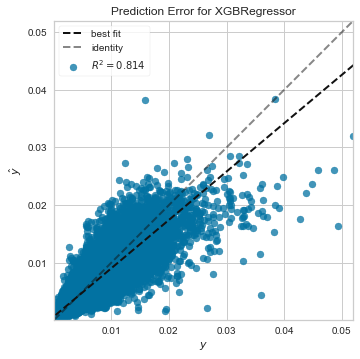

In [203] used 0.2891 MiB RAM in 1.97s, peaked 52.03 MiB above current, total RAM usage 2321.95 MiB


In [203]:
try:
    if X_test.shape[0] > 0:
        from yellowbrick.regressor import PredictionError
        visualizer = PredictionError(est)
        visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        ax_subplot = visualizer.show()        
except ModuleNotFoundError:
    print('no yellowbrick')

In [204]:
if ENV_HOME:
    import eli5
    display(eli5.show_weights(est, feature_names=feature_cols, top=30))

Weight,Feature
0.4394,log_return1_linear
0.2224,log_return1_uniform
0.1428,log_return2_linear
0.0164,log_return2_uniform
0.0060,log_return2_half0half1
0.0058,ask_price2_var
0.0055,size
0.0054,ask_price2_nunique
0.0054,bid_size2_nunique
0.0052,stock_id


In [204] used 0.0078 MiB RAM in 0.20s, peaked 0.00 MiB above current, total RAM usage 2321.96 MiB


In [205]:
if 'feature_importances_' in dir(est):
    feature_col = 'feature_importances_'
elif 'coef_' in dir(est):
    feature_col = 'coef_'
df_features = pd.DataFrame(zip(getattr(est, feature_col), feature_cols), columns=['importance', 'feature']).set_index('importance')
df_features.sort_index(ascending=False)

,feature
importance,
0.439446,log_return1_linear
0.222361,log_return1_uniform
0.142786,log_return2_linear
0.016377,log_return2_uniform
0.005952,log_return2_half0half1
0.005828,ask_price2_var
0.005469,size
0.005417,ask_price2_nunique
0.005350,bid_size2_nunique


In [205] used 0.0078 MiB RAM in 0.19s, peaked 0.00 MiB above current, total RAM usage 2321.96 MiB


# Make predictions

In [206]:
len(stock_ids) # expecting 112

112

In [206] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 2321.96 MiB


In [207]:
if USE_TEST_LOCAL_6_ITEMS: # True if debugging
    # book train as a substitute
    df_test_all = pd.read_csv(os.path.join(ROOT, 'test_local.csv'))
    df_test_all = df_test_all.rename(columns={'target': 'train_target'})
    TEST_FOLDER = 'book_test_local.parquet'
    assert ENV_HOME == True
else:
    df_test_all = pd.read_csv(TEST_CSV)
    if df_test_all.shape[0] == 3: # kaggle test data
        df_test_all = df_test_all[:1] # cut out 2 rows so predictions work    
    TEST_FOLDER = 'book_test.parquet'
print(ROOT, TEST_FOLDER)
df_test_all = df_test_all.set_index(['stock_id', 'time_id'])

show_details(df_test_all)

/home/ian/data/kaggle/optiver_volatility/ book_test.parquet
[2c] 1x1, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [207] used 0.0156 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 2321.98 MiB


In [211]:
test_set_predictions = []
stock_ids_test = get_training_stock_ids(TEST_FOLDER) # all stocks by default

df_test_predictions = pd.DataFrame() # prediction set to build up
for stock_id in tqdm(stock_ids_test):
    df_test_all_X = df_test_all.query('stock_id==@stock_id').copy()
    test_merged = load_data_build_features(stock_id, ROOT, TEST_FOLDER, cols, df_test_all)
    test_set_predictions_X = est.predict(test_merged.reset_index()[list(features) + ['stock_id']])
    df_test_all_X['target'] = test_set_predictions_X
    df_test_predictions = pd.concat((df_test_predictions, df_test_all_X))
    
assert df_test_all.shape[0] == df_test_predictions.shape[0], "Expecting all rows to be predicted"

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.53it/s]


In [211] used 0.2500 MiB RAM in 0.29s, peaked 0.00 MiB above current, total RAM usage 2250.90 MiB


In [212]:
print(f"Writing {df_test_predictions.shape[0]} rows to submission.csv on {datetime.datetime.utcnow()}")
df_test_predictions.reset_index()[['row_id', 'target']].to_csv('submission.csv', index=False)
show_details(df_test_predictions)
print(f'Notebook took {datetime.datetime.utcnow()-t1_notebook_start} to run')

Writing 1 rows to submission.csv on 2021-08-25 16:56:05.041123
[2c] 1x2, 0 nulls, is_view True, is_single_block True, is_consolidated True
Notebook took 0:13:35.935332 to run
In [212] used 0.0000 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 2250.90 MiB


In [213]:
if not ENV_HOME:
    assert USE_ALL_STOCK_IDS, "If we're on Kaggle but not using all stock_ids, we're not ready to submit, so fail here to remind me to change USSE_ALL_STOCK_IDS!"

In [213] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 2250.90 MiB
